In [1]:
from rdkit.Chem import Draw
from rdkit import Chem

In [2]:
import os
os.chdir('../programming_scripts/.')
print(os.getcwd())

from MS2LDA_core import run_lda
from MS2LDA_core import predict_with_lda

#from Spec2Vec_annotation import motif_annotation

from MS2LDA_core import load_mgf
from MS2LDA_core import clean_spectra

from utils import motifs2spectra
from spec2vec import Spec2Vec

C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubstructureIdentification\scripts\programming_scripts


In [3]:
# spectra_path = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubformulaAnnotation\raw_data\_RAWdata1\GNPS-COLLECTIONS-PESTICIDES-POSITIVE.mgf"
# spectra_path = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubformulaAnnotation\raw_data\_RAWdata1\GNPS-NIH-SMALLMOLECULEPHARMACOLOGICALLYACTIVE.mgf"
# spectra_path = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubformulaAnnotation\raw_data\_RAWdata1\GNPS-SCIEX-LIBRARY.mgf"
spectra_path = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\MEDUSA\notebooks\MS2LDA\PDE5_standards_annotated_pos_unique.mgf"

In [4]:
lda_model, corpus, id2word = run_lda(spectra_path=spectra_path, num_motifs=6, iterations=300)

In [5]:
motif_spectra = motifs2spectra(lda_model)

### how to load the embeddings and then still retrieve the smiles afterwards

In [6]:
import pandas as pd

In [7]:
from Spec2Vec_annotation import load_model_and_data
from Spec2Vec_annotation import calc_similarity
from Spec2Vec_annotation import retrieve_top_hits

In [10]:
s2v_model, embeddings_smiles_spectra_DB = load_model_and_data()

In [11]:
smiles = embeddings_smiles_spectra_DB.smiles.to_numpy()
embeddings_DB = embeddings_smiles_spectra_DB.embeddings.to_list()
spectra_DB = embeddings_smiles_spectra_DB.spectra.to_list()

In [12]:
s2v_scores = calc_similarity(s2v_model, motif_spectra, embeddings_DB)

In [22]:
top_scores, top_smiles, top_spectra = retrieve_top_hits(s2v_scores, 1, smiles, spectra_DB)

In [23]:
top_scores

(0.8448314054242583,
 0.843060477311373,
 0.8371824487858033,
 0.8300778459451724,
 0.8261557461106402,
 0.8255554079523351,
 0.8233879142230245,
 0.822574965150096,
 0.8068291489874524,
 0.8068291484679422)

In [24]:
top_smiles

['CCC(C)C(=O)NCC(=O)O',
 'CCC(C)C(=O)NCC(=O)O',
 'CCC(C)/C(=N/CC(=O)O)/O',
 'CCC(C)C(=O)NCC(=O)O',
 'CCC(C)C(=O)NCC(=O)O',
 'CCC(C)/C(=N/CC(=O)O)/O',
 'CCC(C)C(=O)NCC(=O)O',
 'CCOP(=S)(OCC)SCSC(C)(C)C',
 'O=NN(CCCC)CCCC',
 'CCCCN(CCCC)N=O']

(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'a-Methylbutyrylglycine'}, xlabel='m/z', ylabel='Intensity'>)

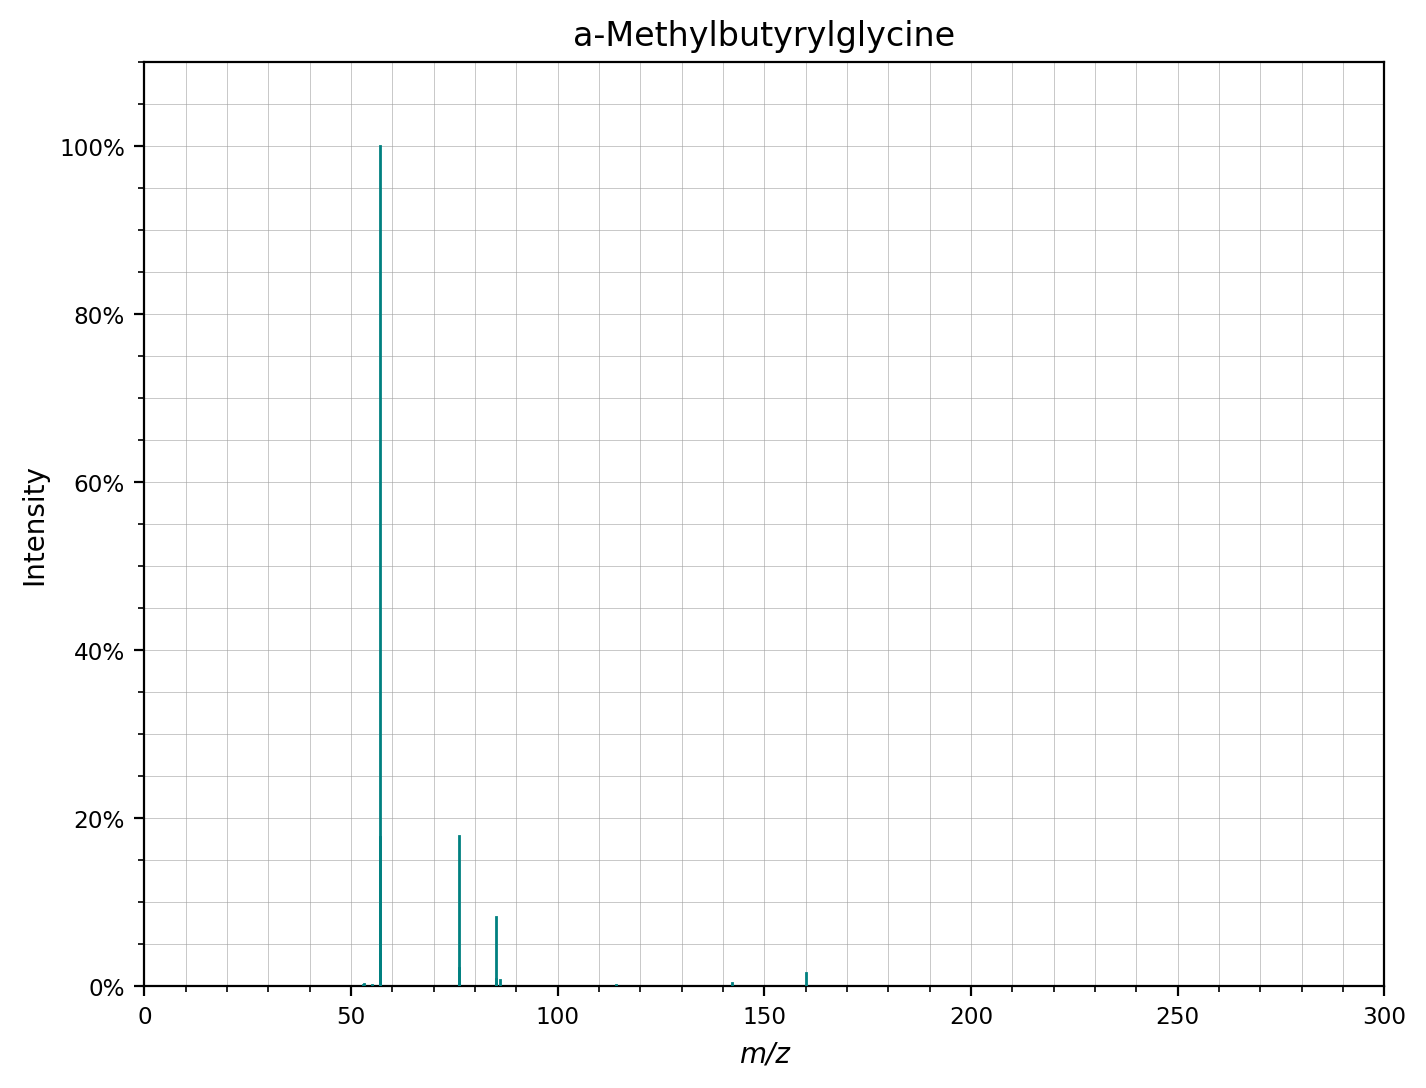

In [30]:
top_spectra[4].plot()

---

### New Part: Retrieve overlaping fragments between spectra with motif spectra

In [14]:
from utils import match_frags_and_losses

In [15]:
# just to get some spectra: it is really important that the spectra are binned
smiles_per_motifs, predicted_motifs, predicted_motifs_distribution, spectra_per_motifs = predict_with_lda(lda_model, spectra_path, id2word)

In [16]:
i = 5

In [17]:
matching_frags, matching_losses = match_frags_and_losses(motif_spectra[i], spectra_per_motifs[i])

In [18]:
matching_frags

[{58.06, 99.09, 491.19},
 {58.06, 99.09, 154.67, 169.1, 505.23},
 {58.06, 99.09, 154.67, 169.1, 489.23},
 {58.06, 99.09, 154.67, 532.26},
 {135.04, 154.67, 204.08, 262.09}]

In [19]:
matching_losses

[set(), set(), set(), set(), set()]

### Intermediate Part: Create new Embeddings

In [20]:
spectra_path_GNPS = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubstructureIdentification\raw_data\GNPS\cleaned_spectra_min_5_peaks.mgf"

In [21]:
s2v_model_path = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubstructureIdentification\scripts\programming_scripts\models\spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model"

In [22]:
from Spec2Vec_annotation import create_embeddings

In [23]:
create_embeddings(s2v_model_path, spectra_path_GNPS)

283261 283261 283261


'Done'

### New Part: Use MassQL to search for matches

In [20]:
from MassQL_annotation import initialize_massql_DB
from MassQL_annotation import add_column
from MassQL_annotation import search_massql_DB

In [24]:
spectra_path_GNPS = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubstructureIdentification\raw_data\GNPS\cleaned_spectra_min_5_peaks.mgf"

In [ ]:
ms1_df, ms2_df = initialize_massql_DB(spectra_path_GNPS)

In [22]:
def generate_query(i):
    input_query_base = "QUERY scaninfo(MS2DATA) WHERE"
    input_query = "QUERY scaninfo(MS2DATA) WHERE"
    for matching_frag in matching_frags[i]:
        if input_query == input_query_base:
            input_query += f" MS2PROD={matching_frag}"
        else:
            input_query += f" AND MS2PROD={matching_frag}"
    for matching_loss in matching_losses[i]:
         if input_query == input_query_base:
            input_query += f" MS2PROD={matching_loss}"
         else:
            input_query += f" AND MS2PROD={matching_loss}"

    return input_query

In [23]:
for i in range(len(matching_frags)):
    input_query = generate_query(i)
    results_df = search_massql_DB(spectra_path, input_query, ms1_df, ms2_df)
    print(results_df.to_numpy())

TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.76it/s]


[[594 491.18946 0 674.1 1 3.3262899999999997 1.0 2 nan
  'CCCC1=NN(C2=C1NC(=NC2=S)C3=C(C=CC(=C3)S(=O)(=O)N4CCN(CC4)C)OCC)C']]
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 67.33it/s]


[[215 505.22332 0 539.78 1 2.53269 1.0 2 nan
  'CCCC1=NN(C2=C1N=C(NC2=O)C3=C(C=CC(=C3)S(=O)(=O)N4CCN(CC4)CCO)OCC)C']]
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.65it/s]


[[222 489.22767 0 540.68 1 2.4637499999999997 1.0 2 nan
  'CCCC1=NC(=C2N1N=C(NC2=O)C3=C(C=CC(=C3)S(=O)(=O)N4CCN(CC4)CC)OCC)C']]
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 81.63it/s]

[[483 532.25912 0 647.78 1 4.54353 1.0 2 nan
  'CCCC1=CN(C2=C1N=C(NC2=O)C3=C(C=CC(=C3)S(=O)(=O)N4CCN(CC4)CCO)OCCC)CC']]
TOTAL QUERIES 1



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.99it/s]

[[313 390.14504 0 622.64 1 4.5408100000000005 1.0 2 nan
  'CN1CC(=O)N2[C@H](Cc3c([nH]c4ccccc34)[C@H]2c2ccc3c(c2)OCO3)C1=O']
 [321 391.14041 0 584.59 1 3.836 1.0 2 nan
  'C1C2C(=O)N(CC(=O)N2C(C3=C1C4=CC=CC=C4N3)C5=CC6=C(C=C5)OCO6)N']
 [420 433.15077 0 588.35 1 4.25434 1.0 2 nan
  'CC(=O)NN1CC(=O)N2C(C1=O)CC3=C(C2C4=CC5=C(C=C4)OCO5)NC6=CC=CC=C36']]
